
Устанавливаем необходимые библиотеки.
1. inference-sdk - для работы с Roboflow API
2. opencv-python - для обработки изображений
3. matplotlib - для визуализации

In [2]:
!pip install -q inference-sdk opencv-python matplotlib Pillow requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00


### Этап 1. Импорт модулей
Импортируем все необходимые модули.

In [22]:
# Импорт необходимых библиотек
import cv2
import supervision as sv
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from collections import Counter
from google.colab import files
import os
import time

### Этап 2. Подготовка данных
Загружаем тестовое изображение с пожаром.

В данном репозитории можно найти датасет с тренировочными изображенями (с  метками)

In [34]:
uploaded = files.upload()

# Файл сохранится в папке /content/
# Выведем список загруженных файлов
for filename in uploaded.keys():
    print(f'Файл "{filename}" загружен')
    # Путь к файлу в Colab всегда будет начинаться с /content/
    image_path = f"/content/{filename}"

print(f"Используем файл: {image_path}")

Saving wildfire_1.jpg to wildfire_1 (1).jpg
Файл "wildfire_1 (1).jpg" загружен

Путь для использования в коде: /content/wildfire_1 (1).jpg
Используем файл: /content/wildfire_1 (1).jpg


### Этап 3: Инициализация клиента Roboflow
Создается экземпляр клиента для общения с Roboflow API.
1. api_url указывает на серверлесс-инфраструктуру Roboflow.
2. api_key (ваш API ключ) нужен для аутентификации запроса.

In [36]:
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="kIuNosI7iEBOp8xSfcaw"
)

### Этап 4. Выполнение предсказания
1. client.run_workflow отправляет изображение на сервер для обработки.
2. workspace_name="grishin-tim": имя рабочего пространства пользователя.
3. workflow_id="find-smokes": конкретная версия модели/воркфлоу, для обнаружения дыма и пожаров.
4. images: словарь с изображениями. В данном случае передается конкретная картинка из Этапа 2.
5. use_cache=True: использует кэш для ускорения работы (ставим True для быстрой работы).

In [37]:
pil_image = Image.open(image_path).convert("RGB")
print(f"Изображение '{os.path.basename(image_path)}' загружено.")

result = client.run_workflow(
    workspace_name="grishin-tim",
    workflow_id="find-smokes",
    images={
        "image": pil_image
      },
    use_cache=True
    )

Изображение 'wildfire_1 (1).jpg' загружено.


### Этап 5: Загрузка и конвертация изображения
Для визуализации нам нужно само изображение, которое мы превратим в NumPy-массив, так как библиотека supervision и OpenCV работают с массивами.

In [38]:
image_np = np.array(pil_image)

### Этап 6. Парсинг
1. Результат от API приходит в виде списка словарей (по одному на каждое отправленное изображение).
* Мы отправляли одно изображение, поэтому берем result[0].
2. Библиотека supervision (sv) значительно упрощает работу с результатами нейросетей.
* sv.Detections.from_inference автоматически разбирает сложный JSON-ответ от Roboflow.
* Он извлекает координаты рамок (bounding boxes), классы и уверенность модели.
* Важно! "predictions" - это ключ в словаре prediction_data, содержащий результаты детекции.

In [39]:
prediction_data = result[0]
detections = sv.Detections.from_inference(prediction_data["predictions"])

### Этап 7: Настройка визуализации
1. BoxAnnotator отвечает за рисование прямоугольников вокруг найденных объектов.
2. LabelAnnotator отвечает за размещение текста (названия класса) над рамкой.
3. Формирование списка подписей.
* zip(...) объединяет имена классов и уверенность модели для каждого обнаруженного объекта.
* f-строка форматирует текст: "fire 0.85" (имя + уверенность с двумя знаками после запятых).

In [40]:
box_annotator = sv.BoxAnnotator()

label_annotator = sv.LabelAnnotator()

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections.data["class_name"], detections.confidence)
]

### Этап 8: Отрисовка на изображении
1. Сначала рисуем рамки на копии исходного изображения (image_np.copy())
* Копия нужна, чтобы не "портить" исходный массив данных, если он понадобится позже чистым
2. Поверх рамок добавляем текстовые метки, используя labels, созданные выше

In [41]:
annotated_image = box_annotator.annotate(
    scene=image_np.copy(),
    detections=detections
)

annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

### Этап 9: Вывод результатов


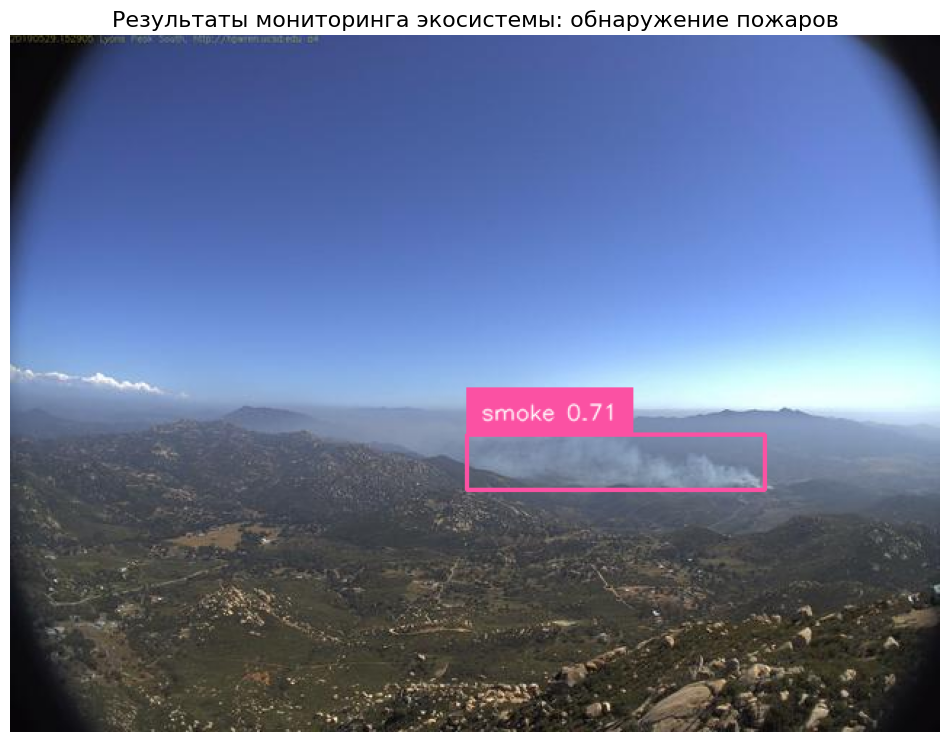

In [42]:
# Список всех распознанных классов.
class_names = detections.data["class_name"]
total_count = len(detections)

if total_count > 0:
    # Обнаружен ли пожар или дым?
    fire_related = any(class_name.lower() in ['fire', 'smoke', 'flame'] for class_name in class_names)
    if fire_related:
        # Находим пожар среди классов
        fire_classes = [name for name in class_names if name.lower() in ['fire', 'smoke', 'flame']]
        fire_class = fire_classes[0] if fire_classes else class_names[0]

        # Вывод для случая пожара
        output_message = f"Внимание! Обнаружен **{fire_class.upper()}**!"
    else:
        # Если обнаружены другие объекты, но не пожар
        most_common_class = Counter(class_names).most_common(1)[0][0]
        output_message = f"Обнаружены объекты типа: **{most_common_class}**"
        print(f"\nРезультат анализа: {output_message}")
else:
    output_message = "На изображении не обнаружено пожаров"
    print(f"\nРезультат анализа: {output_message}")

# Используем Matplotlib для показа изображения
plt.figure(figsize=(12, 12)) # Задаем большой размер фигуры для четкости.
plt.imshow(annotated_image)
plt.title('Результаты мониторинга экосистемы: обнаружение пожаров', fontsize=16)
plt.axis('off') # Убираем оси координат (пиксельную линейку)
plt.show()